In [1]:
# 自動特徴量選択
# 特徴量を追加すると、モデルは複雑になり、過剰適合の可能性が高くなる
# 新しい特徴量を加える場合、または、高次元データ・セットの場合、最も有用な特徴量以外を捨てて特徴量をへらすのはいい考えだ
# 基本的な戦略として、単変量統計、モデルベース選択、反復選択の3つが存在する

In [2]:
# 単変量統計
# 個々の特徴量とターゲットの間に統計的に顕著な関係があるかどうか計算し、最も高い確信度で関連している特徴量が選択される
# クラス分類の場合には、分散分析として知られる手法
# 特徴は単変量である（個々の特徴量を個別に考慮する）こと

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
import numpy as np

cancer = load_breast_cancer()

# シードを指定して乱数を生成
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# ノイズ特徴量をデータに加える
# 最初の30特徴量はデータセットから来たもの、続く50特徴量はノイズ
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
# f_classifとSelectPercentileを使って50%の特徴量を選択
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# 訓練セットを変換
X_train_selected = select.transform(X_train)

# 特徴量が半分に減っている
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_selected.shape: {X_train_selected.shape}")

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


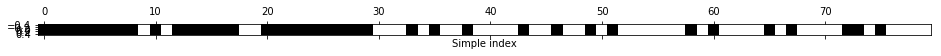

In [6]:
from matplotlib import pyplot as plt
# どの特徴量が使われているかを確認する
mask = select.get_support()
print(mask)
# マスクを可視化する
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Simple index')
plt.show()
# もとの特徴量のほとんどが選択されており、ほとんどのノイズの特徴量が取り除かれている

In [10]:
# ロジスティック回帰の性能を、全ての特徴楼を使った場合と、選択された特徴量だけを使った場合で比較してみる
from sklearn.linear_model import LogisticRegression

# テストデータの変換
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(f"Score with all features: {round(lr.score(X_test, y_test), 3)}") #全ての特徴量を使った際のスコア

lr.fit(X_train_selected, y_train)
print(f"Score with all features: {round(lr.score(X_test_selected, y_test), 3)}") # 選択した特徴量だけを使ったスコア
# 必ずしも、特徴量を削減した場合に性能があがるとは限らない

Score with all features: 0.93
Score with all features: 0.94


In [12]:
# モデルベース特徴量選択
# 教師あり学習モデルを用いて個々の特徴量の重要性を判断し、重要なものだけを残す手法。
# 特徴量選択に使用する学習モデルは、最終的に使う教師あり学習モデルと別でも良い。
# 決定木や決定木をベースにしたモデルには特徴量の重要性そのものをエンコードした feature_importance_ 属性がある
# 線形モデルには係数があり、これも絶対値を取れば、特徴量の重要性を捉えた値として使用できる
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 教師あり学習モデルで得られた特徴量の重要性がしきい値よりも大きい特徴量のみを選択する
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_l1.shape: {X_train_l1.shape}")

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


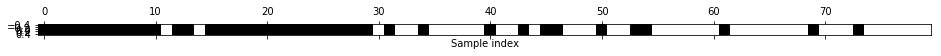

In [13]:
mask = select.get_support()
# マスクを可視化する
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')
plt.show()

In [14]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
# 特徴量を選択することで、性能が上がっていることがわかる
print(f"Test score: {round(score, 3)}")

Test score: 0.951


In [15]:
# 反復特徴量選択
# 異なる特徴量を用いた一連のモデルを作る。方法が2種類ある。
# 1. まったく特徴量を使わないところから、ある基準が満たされるところまで1つづつ特徴量を追加する方法
# 2. 全ての特徴量を使うところから、ある基準が満たされるところまで1つづつ特徴量を取り除く方法


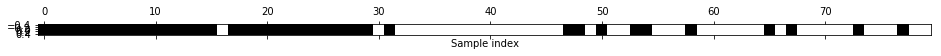

In [19]:
# 再帰的特徴量削減
# 全ての特徴量からモデルを作成して、そのモデルで最も重要度が低い特徴量を削除する

from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)
# 選択された特徴量を可視化する
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')
plt.show()
# ランダムフォレスト分類器を用いて、再帰的特徴量削減で選択された特徴量
# 特徴量の1つがなくなっている

In [21]:
# RFEを用いて選択した特徴量を用いたロジスティック回帰モデル
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print(f"Test score: {round(score, 3)}")

# RFEの内部で用いられたモデルで計算することもできる
print(f"Test score: {round(select.score(X_test, y_test), 3)}")
# RFEで用いられたランダムフォレストの性能は、選択された特徴量で訓練したロジスティック回帰モデルと同じである
# つまり、適切な特徴量を選んだことによって、線形モデルの性能がランダムフォレストと同じになったということ
# 機械学習アルゴリズムに対してどの特徴量を入力として使ったらよいかわからない場合には、自動特徴量選択は有用である.
# また、予測を高速化したい場合や、解釈しやすいモデルを構築したい場合などに,必要な特徴量を減らすのにも役に立つ
# 実世界のデータでは、特徴量選択で性能が大幅に向上することはあまりない。

Test score: 0.951
Test score: 0.951
